In [1]:
import pandas as pd

# Load datasets
patients = pd.read_csv('patients.csv')
providers = pd.read_csv('providers.csv')
organizations = pd.read_csv('organizations.csv')
encounters = pd.read_csv('encounters.csv')
conditions = pd.read_csv('conditions.csv')
medications = pd.read_csv('medications.csv')


In [2]:
patients_selected = patients[['Id', 'GENDER', 'RACE', 'ETHNICITY', 'BIRTHDATE', 'ZIP', 'MARITAL']]
providers_selected = providers[['Id', 'NAME', 'ORGANIZATION', 'SPECIALITY']]
organizations_selected = organizations[['Id', 'NAME']]
encounters_selected = encounters[['Id', 'PATIENT', 'PROVIDER', 'ORGANIZATION', 'START', 'STOP']]
conditions_selected = conditions[['CODE', 'PATIENT', 'ENCOUNTER']].rename(columns={'CODE': 'DISEASE_Id'})
medications_selected = medications[['CODE', 'PATIENT', 'ENCOUNTER']].rename(columns={'CODE': 'MEDICATION_Id'})

In [3]:
patients_selected['AGE'] = patients_selected['BIRTHDATE'].apply(lambda x: 2024 - int(x[:4]))
patients_selected['ZIP'] = patients_selected['ZIP'].fillna(0).apply(lambda x: int(x))
patients_selected = patients_selected.drop(['BIRTHDATE'], axis=1)

<ipython-input-3-9a8b138dcc3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_selected['AGE'] = patients_selected['BIRTHDATE'].apply(lambda x: 2024 - int(x[:4]))
<ipython-input-3-9a8b138dcc3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_selected['ZIP'] = patients_selected['ZIP'].fillna(0).apply(lambda x: int(x))


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize an empty graph
G = nx.Graph()

# Add patient nodes
for _, row in patients_selected.iterrows():
    G.add_node(row['Id'], type='patient', gender=row['GENDER'], race=row['RACE'], ethnicity=row['ETHNICITY'], age=row['AGE'], zip=row['ZIP'], marital=row['MARITAL'])

# Add provider nodes
for _, row in providers_selected.iterrows():
    G.add_node(row['Id'], type='provider', name=row['NAME'], specialty=row['SPECIALITY'])

# Add organization nodes
for _, row in organizations_selected.iterrows():
    G.add_node(row['Id'], type='organization', name=row['NAME'])

# Add disease nodes
for _, row in conditions_selected.iterrows():
    G.add_node(row['DISEASE_Id'], type='disease')

# Add medication nodes
for _, row in medications_selected.iterrows():
    G.add_node(row['MEDICATION_Id'], type='medication')

# Add edges based on encounters
for _, row in encounters_selected.iterrows():
    patient_id = row['PATIENT']
    provider_id = row['PROVIDER']
    organization_id = row['ORGANIZATION']

    # Add edge between patient and provider
    if not G.has_edge(patient_id, provider_id):
        G.add_edge(patient_id, provider_id, relationship='encounter')

    # Add edge between provider and organization
    if not G.has_edge(provider_id, organization_id):
        G.add_edge(provider_id, organization_id, relationship='employed_at')

# Add edges based on conditions
for _, row in conditions_selected.iterrows():
    patient_id = row['PATIENT']
    disease_id = row['DISEASE_Id']

    # Add edge between patient and provider
    if not G.has_edge(patient_id, disease_id):
        G.add_edge(patient_id, disease_id, relationship='conditions')

# Add edges based on medications
for _, row in medications_selected.iterrows():
    patient_id = row['PATIENT']
    medication_id = row['MEDICATION_Id']

    # Add edge between patient and provider
    if not G.has_edge(patient_id, medication_id):
        G.add_edge(patient_id, medication_id, relationship='medications')

# Visualize the network
# plt.figure(figsize=(15, 10))
# pos = nx.spring_layout(G, k=0.15, iterations=20)
# node_colors = []
# for node in G.nodes(data=True):
#     if node[1]['type'] == 'patient':
#         node_colors.append('blue')
#     elif node[1]['type'] == 'provider':
#         node_colors.append('green')
#     else:
#         node_colors.append('red')

# nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, alpha=0.6)
# nx.draw_networkx_edges(G, pos, alpha=0.4)
# plt.title('Social Health Network')
# plt.axis('off')
# plt.show()


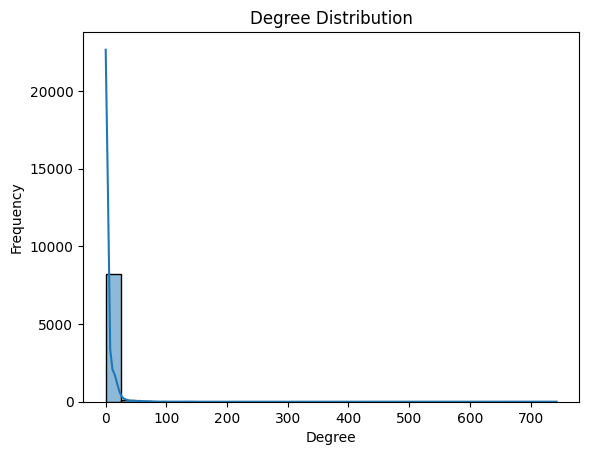

Average Clustering Coefficient: 0.0000
Number of Communities Detected: 4780


In [ ]:
import seaborn as sns

# Degree Distribution
degrees = [deg for node, deg in G.degree()]
sns.histplot(degrees, bins=30, kde=True)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# Clustering Coefficient
clustering_coeff = nx.average_clustering(G)
print(f'Average Clustering Coefficient: {clustering_coeff:.4f}')

# Community Detection (e.g., using Girvan-Newman)
from networkx.algorithms.community import girvan_newman

communities = girvan_newman(G)
limited = next(communities)
print(f'Number of Communities Detected: {len(limited)}')

In [ ]:
import random
def extract_subgraph(G, patient_ids, depth=1):
    """
    Extracts a subgraph containing selected patients and their connections up to a specified depth.

    Parameters:
    - G: Original NetworkX graph.
    - patient_ids: List of patient IDs to include.
    - depth: Number of connection levels to include (default=1).

    Returns:
    - subG: Extracted subgraph.
    """
    sub_nodes = set(patient_ids)
    current_level = set(patient_ids)

    for _ in range(depth):
        neighbors = set()
        for node in current_level:
            neighbors.update(G.neighbors(node))
        sub_nodes.update(neighbors)
        current_level = neighbors

    subG = G.subgraph(sub_nodes).copy()
    return subG

# Randomly select n patient IDs
n = 5
random.seed(42)  # For reproducibility
selected_patients = random.sample(list(patients_selected['Id']), n)
print("Selected Patient IDs (Random):", selected_patients)
# Extract subgraph with depth=1 (selected patients and their direct connections)
subG = extract_subgraph(G, selected_patients, depth=1)
print(f"Subgraph has {subG.number_of_nodes()} nodes and {subG.number_of_edges()} edges.")

Selected Patient IDs (Random): ['73ccae2b-09be-48be-b6f8-320bc4df146a', '32885ae1-d031-4f52-8f91-0e5196f5462a', 'dda6a788-814a-48f2-8ebe-bc57e4cefd92', 'ca24f616-30cc-4351-aca9-1b49297de076', '20c3ca32-ec09-4e7c-abab-9f7711cbe235']
Subgraph has 73 nodes and 84 edges.


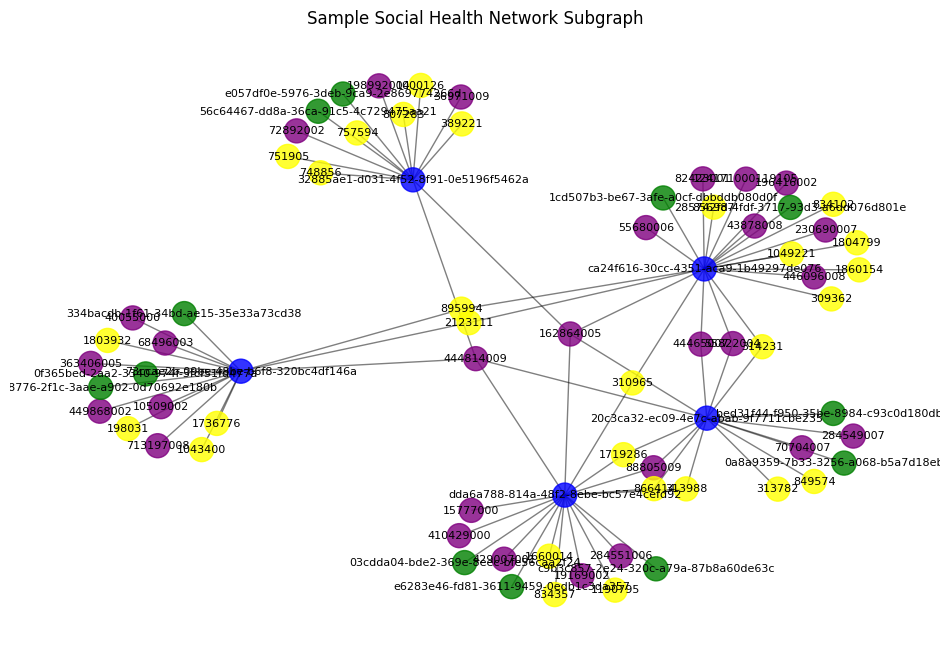

In [ ]:
# Define colors based on node type
node_colors = []
for node, data in subG.nodes(data=True):
    if data['type'] == 'patient':
        node_colors.append('blue')
    elif data['type'] == 'provider':
        node_colors.append('green')
    elif data['type'] == 'organization':
        node_colors.append('red')
    elif data['type'] == 'disease':
        node_colors.append('purple')
    else:
        node_colors.append('yellow')  # medication

# Draw the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.1, iterations=50)  # Adjust 'k' for spacing

# Draw nodes
nx.draw_networkx_nodes(subG, pos, node_size=300, node_color=node_colors, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(subG, pos, alpha=0.5)

# Draw labels (optional)
labels = {node: node for node in subG.nodes()}
nx.draw_networkx_labels(subG, pos, labels, font_size=8)

plt.title('Sample Social Health Network Subgraph')
plt.axis('off')
plt.show()


In [ ]:
# Find unique combinations in the dataset
quasi_identifiers = ['AGE', 'GENDER', 'ZIP']
unique_combinations = patients_selected.groupby(quasi_identifiers).size().reset_index(name='count')

# Identify groups with count < k (e.g., k=5)
k = 5
at_risk_groups = unique_combinations[unique_combinations['count'] < k]
print(f'Number of groups at risk of re-identification (count < {k}): {len(at_risk_groups)}')

# Example: List at-risk combinations
print(at_risk_groups.head())


Number of groups at risk of re-identification (count < 5): 708
   AGE GENDER   ZIP  count
0    4      F  2118      1
1    4      F  2122      1
2    4      F  2136      1
3    4      F  2453      1
4    5      F     0      2


In [ ]:
# Example: Identify providers with high degree (connected to many patients)
provider_degrees = [(node, deg) for node, deg in G.degree() if G.nodes[node]['type'] == 'provider']
high_degree_providers = sorted(provider_degrees, key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Providers by Degree:")
for provider, degree in high_degree_providers:
    print(f"Provider ID: {provider}, Degree: {degree}")

# An attacker might target these high-degree providers to infer information about their patients


Top 5 Providers by Degree:
Provider ID: e6283e46-fd81-3611-9459-0edb1c3da357, Degree: 71
Provider ID: f4eb93d1-9187-3cfb-83a4-6d9cd77f7df6, Degree: 68
Provider ID: c9b3c857-2e24-320c-a79a-87b8a60de63c, Degree: 63
Provider ID: af42f305-3f0c-396d-8303-9cbdb900a516, Degree: 46
Provider ID: 7bd4e666-a82d-3ad1-bc7c-b49eb726577b, Degree: 44


In [5]:
def mondrian_k_anonymity(df, quasi_ids, k):
    def split_partition(partition, quasi_ids, k):
        # If the partition size is less than 2k, cannot split further
        if len(partition) < 2 * k:
            return [partition]

        # Select the attribute with the widest range
        ranges = {attr: partition[attr].max() - partition[attr].min() for attr in quasi_ids}
        split_attr = max(ranges, key=ranges.get)

        # Sort the partition based on the split attribute
        sorted_partition = partition.sort_values(by=split_attr).reset_index(drop=True)

        # Find the split point
        split_index = len(sorted_partition) // 2
        while split_index < len(sorted_partition) and sorted_partition.iloc[split_index][split_attr] == sorted_partition.iloc[split_index - 1][split_attr]:
            split_index += 1

        # Ensure both partitions have at least k records
        if split_index < k or (len(sorted_partition) - split_index) < k:
            return [partition]

        # Split the partition
        left = sorted_partition.iloc[:split_index]
        right = sorted_partition.iloc[split_index:]

        # Recursively split the partitions
        return split_partition(left, quasi_ids, k) + split_partition(right, quasi_ids, k)

    def generalize(partition, quasi_ids):
        generalized = partition.copy()
        for attr in quasi_ids:
            min_val = partition[attr].min()
            max_val = partition[attr].max()
            generalized[attr] = f"{min_val}-{max_val}"
        return generalized

    # Begin Mondrian partitioning
    partitions = split_partition(df, quasi_ids, k)

    # Generalize each partition
    generalized_partitions = [generalize(part, quasi_ids) for part in partitions]

    # Concatenate all generalized partitions
    anonymized_df = pd.concat(generalized_partitions).reset_index(drop=True)

    groups = anonymized_df.groupby(quasi_ids).size().reset_index(name='count')
    at_risk = groups[groups['count'] < k]

    return anonymized_df, len(at_risk)


In [6]:
quasi_identifiers = ['AGE', 'ZIP']
k = 5

mondrian_df, mondrian_at_risk = mondrian_k_anonymity(patients_selected, quasi_identifiers, k)

print(mondrian_at_risk)

0


In [7]:
def dynamic_k_anonymity(df, quasi_ids, k, k_importance_coefficients, attribute_anonymizations, generalization_levels):
    def split_partition(partition, quasi_ids, k):
        # If the partition size is less than 2k, cannot split further
        if len(partition) < 2 * k:
            return [partition]

        # Select the attribute with the widest range
        ranges = {attr: partition[attr].max() - partition[attr].min() for attr in quasi_ids}
        split_attr = max(ranges, key=ranges.get)

        # Sort the partition based on the split attribute
        sorted_partition = partition.sort_values(by=split_attr).reset_index(drop=True)

        # Find the split point
        split_index = len(sorted_partition) // 2
        while split_index < len(sorted_partition) and sorted_partition.iloc[split_index][split_attr] == sorted_partition.iloc[split_index - 1][split_attr]:
            split_index += 1

        # Ensure both partitions have at least k records
        if split_index < k or (len(sorted_partition) - split_index) < k:
            return [partition]

        # Split the partition
        left = sorted_partition.iloc[:split_index]
        right = sorted_partition.iloc[split_index:]

        # Recursively split the partitions
        return split_partition(left, quasi_ids, k) + split_partition(right, quasi_ids, k)

    def generalize(partition, quasi_ids):
        generalized = partition.copy()
        for attr in quasi_ids:
            min_val = partition[attr].min()
            max_val = partition[attr].max()
            anonymization_level = generalization_levels[attr]
            anonymization_function = attribute_anonymizations[attr][anonymization_level]
            generalized[attr] = partition[attr].apply(lambda num: anonymization_function(num, partition[attr]))
        return generalized


    # Pick the dominant qid
    ranges = {attr: df[attr].max() - df[attr].min() for attr in quasi_ids}
    split_attr = max(ranges, key=ranges.get)
    dynamic_k = int(k * k_importance_coefficients[split_attr])

    # Begin Mondrian partitioning
    partitions = split_partition(df, quasi_ids, dynamic_k)

    # Generalize each partition
    generalized_partitions = [generalize(part, quasi_ids) for part in partitions]

    # Concatenate all generalized partitions
    anonymized_df = pd.concat(generalized_partitions).reset_index(drop=True)

    groups = anonymized_df.groupby(quasi_ids).size().reset_index(name='count')
    at_risk = groups[groups['count'] < k]

    return anonymized_df, len(at_risk)


In [9]:
# 0 -> not important, 1 -> important
k_importance_coefficients = {
    'AGE': 1,
    'ZIP': 0.7
}
generalization_levels = {
    'AGE': 2,
    'ZIP': 2,
}

def unchanged(num, df):
    return f"{num}-{num}"

def nearest_x_bin(num, df, x):
    return  f"{(num // x) * x}-{(num // x) * x + x}"

def narrow_min_max_interval(num, df):
    min_val = df.min()
    max_val = df.max()
    mean_val = df.mean()
    left = int((min_val + mean_val) / 2)
    right = int((max_val + mean_val) / 2)
    return f"{left}-{right}"

def min_max_interval(num, df):
    min_val = df.min()
    max_val = df.max()
    return f"{min_val}-{max_val}"

attribute_anonymizations = {
    "AGE": {
        0: unchanged,  # Exact age
        1: lambda num, df: nearest_x_bin(num, df, 5), # e.g. 14 -> (10, 15)
        2: lambda num, df: narrow_min_max_interval(num, df),
        3: lambda num, df: min_max_interval(num, df)

    },
    "ZIP": {
        0: unchanged,  # Exact ZIP
        1: lambda num, df: nearest_x_bin(num, df, 10), # Generalize to nearest 10, 100X -> 1000
        2: lambda num, df: narrow_min_max_interval(num, df),
        3: lambda num, df: min_max_interval(num, df)
    }
}
k = 5
dynamic_k_anonymized_df, dynamic_k_at_risk = dynamic_k_anonymity(
        patients_selected, ["ZIP", "AGE"], k,
        k_importance_coefficients, attribute_anonymizations,
        generalization_levels
    )

print(dynamic_k_at_risk)

102


In [10]:
def calculate_ncp(original_df, anonymized_df, quasi_ids):
    """
    Calculates the Normalized Certainty Penalty (NCP) for the anonymized DataFrame.

    Args:
        original_df (pd.DataFrame): The original DataFrame.
        anonymized_df (pd.DataFrame): The anonymized DataFrame.
        quasi_ids (list): List of quasi-identifier column names.

    Returns:
        float: The normalized certainty penalty.
    """
    total_ncp = 0
    total_attributes = len(quasi_ids)

    for attr in quasi_ids:
        original_min = original_df[attr].min()
        original_max = original_df[attr].max()
        range_original = original_max - original_min

        # Calculate the range in the anonymized data
        anonymized_ranges = anonymized_df[attr].apply(lambda x: int(x.split('-')[1]) - int(x.split('-')[0]))
        avg_range = anonymized_ranges.mean()

        # Normalize NCP for this attribute
        ncp_attr = avg_range / range_original
        total_ncp += ncp_attr

    # Average NCP across all quasi-identifiers
    normalized_ncp = total_ncp / total_attributes
    return normalized_ncp

In [11]:
print(calculate_ncp(patients_selected, mondrian_df, ['ZIP', 'AGE']))

0.08312547016221479


In [12]:
print(calculate_ncp(patients_selected, dynamic_k_anonymized_df, ['ZIP', 'AGE']))

0.02676370781704414


In [13]:
import pandas as pd

def calculate_discernibility_metric(df, quasi_identifiers):
    """
    Calculates the Discernibility Metric for a k-anonymized dataset.

    Parameters:
    - df: pandas DataFrame containing the anonymized data.
    - quasi_identifiers: list of column names used as quasi-identifiers.

    Returns:
    - DM: Discernibility Metric value.
    """
    # Group by quasi-identifiers to form equivalence classes
    equivalence_classes = df.groupby(quasi_identifiers).size()

    # Calculate DM by summing the squares of the sizes of equivalence classes
    DM = (equivalence_classes ** 2).sum()

    return DM

def calculate_normalized_dm(df, quasi_identifiers):
    """
    Calculates the Normalized Discernibility Metric (NDM).

    Parameters:
    - df: pandas DataFrame containing the anonymized data.
    - quasi_identifiers: list of column names used as quasi-identifiers.

    Returns:
    - NDM: Normalized Discernibility Metric value.
    """
    total_records = len(df)
    DM = calculate_discernibility_metric(df, quasi_identifiers)
    NDM = DM / (total_records ** 2)
    return NDM

In [16]:
quasi_identifiers = ['AGE', 'GENDER', 'ZIP']
print("original data:", calculate_discernibility_metric(patients_selected, quasi_identifiers))
print("original data normalized:", calculate_normalized_dm(patients_selected, quasi_identifiers))

print("mondrian:", calculate_discernibility_metric(mondrian_df, quasi_identifiers))
print("mondrian normalized:", calculate_normalized_dm(mondrian_df, quasi_identifiers))

original data: 3051
original data normalized: 0.0022249918139845585
mondrian: 5777
mondrian normalized: 0.004212972045030742


In [15]:
quasi_identifiers = ['AGE', 'GENDER', 'ZIP']
print("original data:", calculate_discernibility_metric(patients_selected, quasi_identifiers))
print("original data normalized:", calculate_normalized_dm(patients_selected, quasi_identifiers))

print("dynamic k-anonymity:", calculate_discernibility_metric(dynamic_k_anonymized_df, quasi_identifiers))
print("dynamic k-anonymity normalized:", calculate_normalized_dm(dynamic_k_anonymized_df, quasi_identifiers))

original data: 3051
original data normalized: 0.0022249918139845585
dynamic k-anonymity: 4545
dynamic k-anonymity normalized: 0.0033145158290920416


In [21]:
# 0 -> not important, 1 -> important
k_importance_coefficients = {
    'AGE': 1,
    'ZIP': 0.7
}
generalization_levels = {
    'AGE': 2,
    'ZIP': 2,
}

def unchanged(num, df):
    return f"{num}-{num}"

def nearest_x_bin(num, df, x):
    return  f"{(num // x) * x}-{(num // x) * x + x}"

def narrow_min_max_interval(num, df):
    min_val = df.min()
    max_val = df.max()
    mean_val = df.mean()
    left = int((min_val + mean_val) / 2)
    right = int((max_val + mean_val) / 2)
    return f"{left}-{right}"

def min_max_interval(num, df):
    min_val = df.min()
    max_val = df.max()
    return f"{min_val}-{max_val}"

attribute_anonymizations = {
    "AGE": {
        0: unchanged,  # Exact age
        1: lambda num, df: nearest_x_bin(num, df, 5), # e.g. 14 -> (10, 15)
        2: lambda num, df: narrow_min_max_interval(num, df),
        3: lambda num, df: min_max_interval(num, df)

    },
    "ZIP": {
        0: unchanged,  # Exact ZIP
        1: lambda num, df: nearest_x_bin(num, df, 10), # Generalize to nearest 10, 100X -> 1000
        2: lambda num, df: narrow_min_max_interval(num, df),
        3: lambda num, df: min_max_interval(num, df)
    }
}

In [25]:
quasi_identifiers = ['AGE', 'GENDER', 'ZIP']
at_risks = []
ncps = []
dms = []
total_num_records = len(patients_selected)

baseline_ncp = 0
baseline_dm = calculate_normalized_dm(patients_selected, quasi_identifiers)

for k in range(2, 200):
    if k % 10 == 0:
        print("k:", k)
    # baseline
    unique_combinations = patients_selected.groupby(quasi_identifiers).size().reset_index(name='count')
    baseline_at_risk = len(unique_combinations[unique_combinations['count'] < k])

    # mondrian
    mondrian_df, mondrian_at_risk = mondrian_k_anonymity(patients_selected, ['AGE', 'ZIP'], k)
    mondrian_ncp = calculate_ncp(patients_selected, mondrian_df, ['AGE', 'ZIP'])
    mondrian_dm = calculate_normalized_dm(mondrian_df, quasi_identifiers)

    # dynamic k anonymity
    dynamic_k_anonymized_df, dynamic_k_at_risk = dynamic_k_anonymity(patients_selected, ['AGE', 'ZIP'], k, k_importance_coefficients, attribute_anonymizations, generalization_levels)
    dynamic_k_ncp = calculate_ncp(patients_selected, dynamic_k_anonymized_df, ['AGE', 'ZIP'])
    dynamic_k_dm = calculate_normalized_dm(dynamic_k_anonymized_df, quasi_identifiers)

    at_risks.append((baseline_at_risk/total_num_records, mondrian_at_risk/total_num_records, dynamic_k_at_risk/total_num_records))
    ncps.append((baseline_ncp, mondrian_ncp, dynamic_k_ncp))
    dms.append((baseline_dm, mondrian_dm, dynamic_k_dm))

# Extracting values from at_risks
baseline_at_risks = [item[0] for item in at_risks]
mondrian_at_risks = [item[1] for item in at_risks]
dynamic_at_risks = [item[2] for item in at_risks]

# Extracting values from ncps
baseline_ncps = [item[0] for item in ncps]
mondrian_ncps = [item[1] for item in ncps]
dynamic_ncps = [item[2] for item in ncps]

# Extracting values from dms
baseline_dms = [item[0] for item in dms]
mondrian_dms = [item[1] for item in dms]
dynamic_dms = [item[2] for item in dms]


k: 10
k: 20
k: 30
k: 40
k: 50
k: 60
k: 70
k: 80
k: 90
k: 100
k: 110
k: 120
k: 130
k: 140
k: 150
k: 160
k: 170
k: 180
k: 190


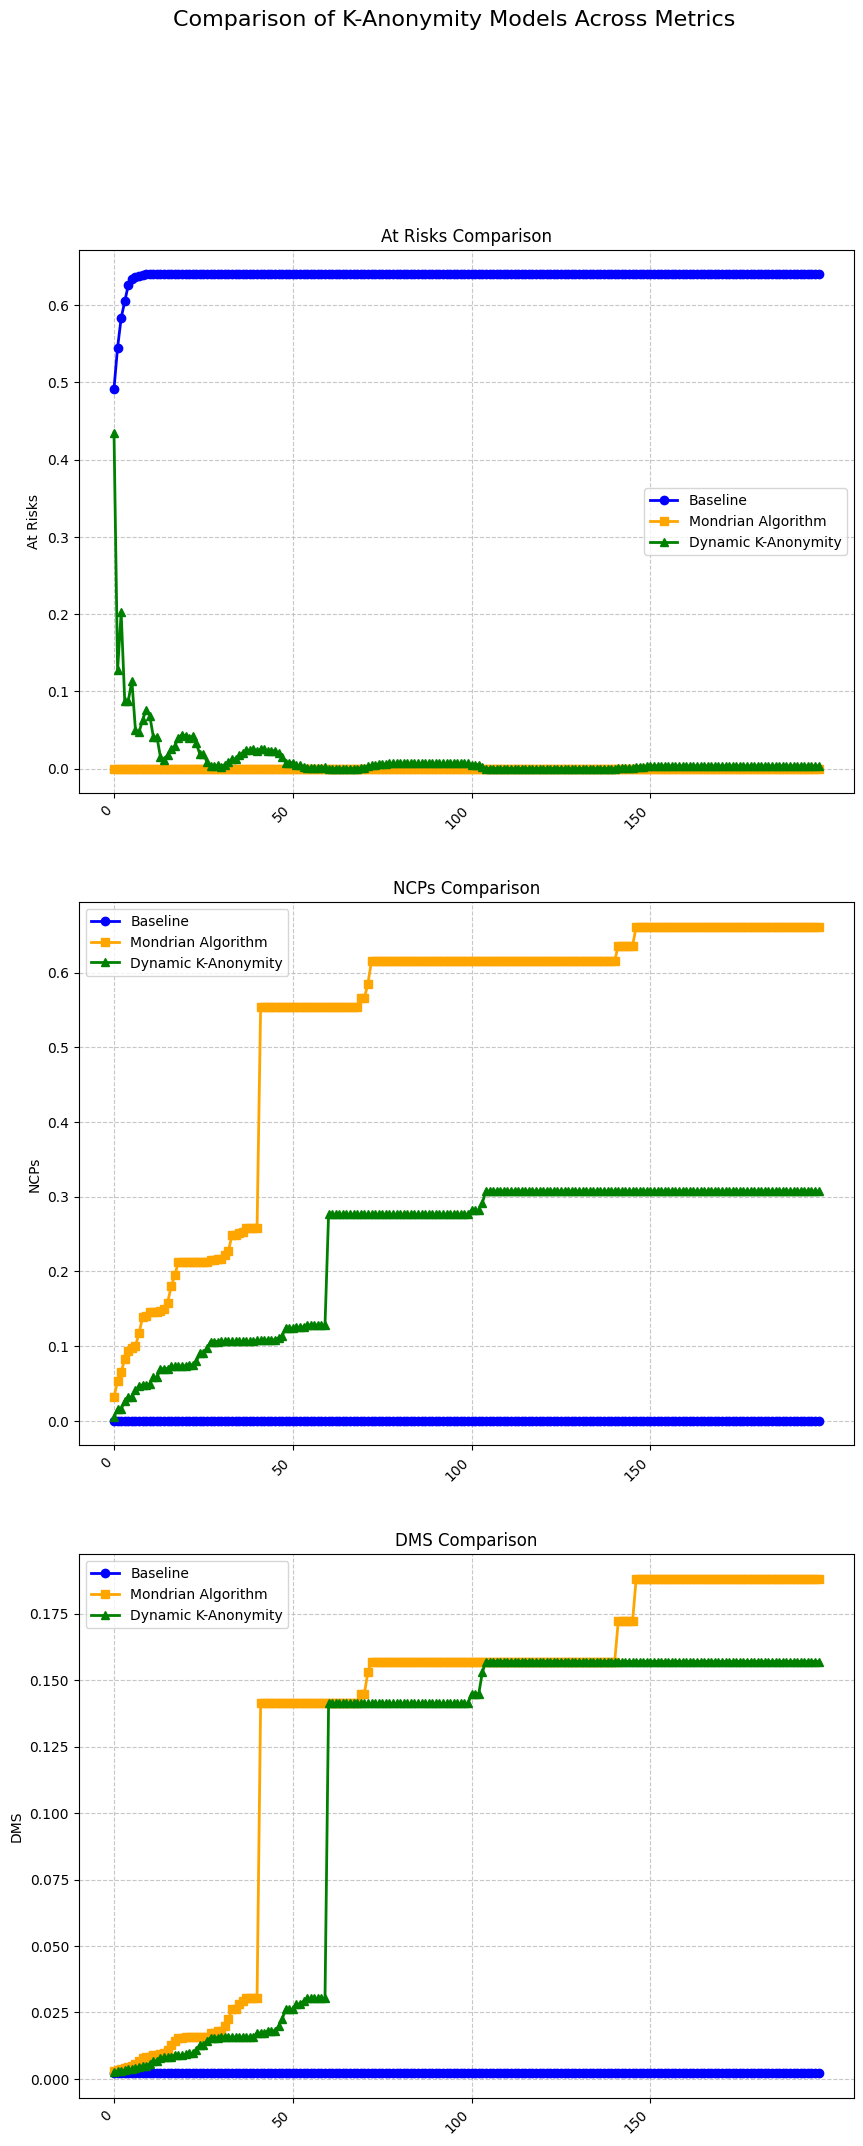

In [26]:
import matplotlib.pyplot as plt

# Number of data points
num_points = len(mondrian_ncps)

x_labels = [k for k in range(num_points)]

# x positions
import numpy as np
x = np.arange(num_points)  # the label locations

# Width of the bars
width = 0.2  # adjust as needed
x_step = 50

# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 24))  # 3 rows, 1 column
fig.suptitle('Comparison of K-Anonymity Models Across Metrics', fontsize=16)

# Plot for at_risks
axs[0].plot(x, baseline_at_risks, marker='o', label='Baseline', color='blue', linewidth=2)
axs[0].plot(x, mondrian_at_risks, marker='s', label='Mondrian Algorithm', color='orange', linewidth=2)
axs[0].plot(x, dynamic_at_risks, marker='^', label='Dynamic K-Anonymity', color='green', linewidth=2)

axs[0].set_ylabel('At Risks')
axs[0].set_title('At Risks Comparison')
axs[0].set_xticks(x[::x_step])
axs[0].set_xticklabels(x_labels[::x_step], rotation=45, ha='right')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot for ncps
axs[1].plot(x, baseline_ncps, marker='o', label='Baseline', color='blue', linewidth=2)
axs[1].plot(x, mondrian_ncps, marker='s', label='Mondrian Algorithm', color='orange', linewidth=2)
axs[1].plot(x, dynamic_ncps, marker='^', label='Dynamic K-Anonymity', color='green', linewidth=2)

axs[1].set_ylabel('NCPs')
axs[1].set_title('NCPs Comparison')
axs[1].set_xticks(x[::x_step])
axs[1].set_xticklabels(x_labels[::x_step], rotation=45, ha='right')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

# Plot for dms
axs[2].plot(x, baseline_dms, marker='o', label='Baseline', color='blue', linewidth=2)
axs[2].plot(x, mondrian_dms, marker='s', label='Mondrian Algorithm', color='orange', linewidth=2)
axs[2].plot(x, dynamic_dms, marker='^', label='Dynamic K-Anonymity', color='green', linewidth=2)

axs[2].set_ylabel('DMS')
axs[2].set_title('DMS Comparison')
axs[2].set_xticks(x[::x_step])
axs[2].set_xticklabels(x_labels[::x_step], rotation=45, ha='right')
axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.7)
